# Artificial Intelligence in Finance

## Vectorized Backtesting

In [1]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

## Backtesting an SMA-Based Strategy

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
symbol = 'EUR='

In [4]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()[symbol])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [6]:
data['SMA1'] = data[symbol].rolling(42).mean()

In [7]:
data['SMA2'] = data[symbol].rolling(258).mean()

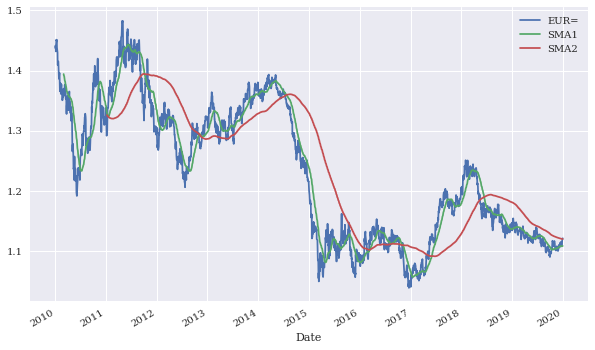

In [8]:
data.plot(figsize=(10, 6));

In [9]:
data.dropna(inplace=True)

In [10]:
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [11]:
data['p'] = data['p'].shift(1)

In [12]:
data.dropna(inplace=True)

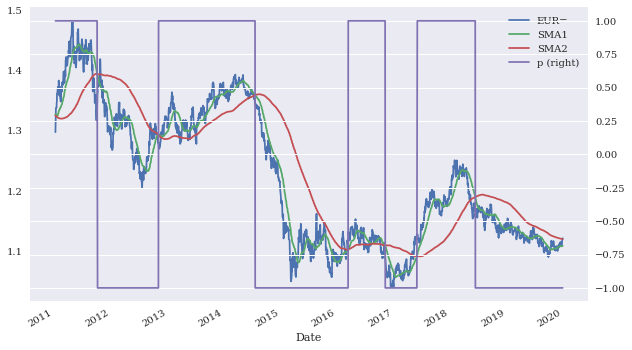

In [13]:
data.plot(figsize=(10, 6), secondary_y='p');

In [ ]:
data['r'] = np.log(data[symbol] / data[symbol].shift(1))

In [ ]:
data.dropna(inplace=True)

In [ ]:
data['s'] = data['p'] * data['r']

In [ ]:
data[['r', 's']].sum().apply(np.exp)  # gross performance

In [ ]:
data[['r', 's']].sum().apply(np.exp) - 1  # net performance

In [ ]:
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
sum(data['p'].diff() != 0) + 1

In [ ]:
pc = 0.005

In [ ]:
data['s_'] = np.where(data['p'].diff() != 0,
                      data['s'] - pc, data['s'])

In [ ]:
# data['s_'].iloc[0] -= pc

In [ ]:
data['s_'].iloc[-1] -= pc

In [ ]:
data[['r', 's', 's_']][data['p'].diff() != 0]

In [ ]:
data[['r', 's', 's_']].sum().apply(np.exp)

In [ ]:
data[['r', 's', 's_']].sum().apply(np.exp) - 1

In [ ]:
data[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
data[['r', 's', 's_']].std()

In [ ]:
data[['r', 's', 's_']].std() * math.sqrt(252)

## Backtesting a Daily DNN-Based Strategy

In [ ]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()[symbol])

In [ ]:
data.info()

In [ ]:
lags = 5

In [ ]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [ ]:
data, cols = add_lags(data, symbol, lags, window=20)

In [ ]:
import random
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [ ]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

In [ ]:
optimizer = Adam(learning_rate=0.0001)

In [ ]:
def create_model(hl=2, hu=128, dropout=False, rate=0.3,
                regularize=False, reg=l1(0.0005),
                optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                 activity_regularizer=reg,  
                 activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                     activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [ ]:
split = '2018-01-01'

In [ ]:
train = data.loc[:split].copy()

In [ ]:
np.bincount(train['d'])

In [ ]:
mu, std = train.mean(), train.std()

In [ ]:
train_ = (train - mu) / std

In [ ]:
set_seeds()
model = create_model(hl=2, hu=64)

In [ ]:
%%time 
model.fit(train_[cols], train['d'],
        epochs=20, verbose=False,
        validation_split=0.2, shuffle=False)

In [ ]:
model.evaluate(train_[cols], train['d'])

In [ ]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, 0)

In [ ]:
train['p'] = np.where(train['p'] == 1, 1, -1)

In [ ]:
train['p'].value_counts()

In [ ]:
train['s'] = train['p'] * train['r']

In [ ]:
train[['r', 's']].sum().apply(np.exp)

In [ ]:
train[['r', 's']].sum().apply(np.exp)  - 1

In [ ]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
test = data.loc[split:].copy()

In [ ]:
test_ = (test - mu) / std

In [ ]:
model.evaluate(test_[cols], test['d'])

In [ ]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

In [ ]:
test['p'].value_counts()

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

In [ ]:
test[['r', 's']].sum().apply(np.exp) - 1

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
sum(test['p'].diff() != 0) + 1

In [ ]:
spread = 0.00012
pc = spread / data[symbol].mean()
print(f'{pc:.6f}')

In [ ]:
test['s_'] = np.where(test['p'].diff() != 0,
                      test['s'] - pc, test['s'])

In [ ]:
# test['s_'].iloc[0] -= pc

In [ ]:
test['s_'].iloc[-1] -= pc

In [ ]:
test[['r', 's', 's_']].sum().apply(np.exp)

In [ ]:
test[['r', 's', 's_']].sum().apply(np.exp) - 1

In [ ]:
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Backtesting an Intraday DNN-Based Strategy

In [ ]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [ ]:
symbol = 'EUR='

In [ ]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                    parse_dates=True).dropna()['CLOSE'])
data.columns = [symbol]

In [ ]:
data = data.resample('5min', label='right').last().ffill()

In [ ]:
data.info()

In [ ]:
data.head()

In [ ]:
data[symbol].plot(figsize=(10, 6));

In [ ]:
lags = 5

In [ ]:
data, cols = add_lags(data, symbol, lags, window=20)

In [ ]:
split = int(len(data) * 0.85)

In [ ]:
train = data.iloc[:split].copy()

In [ ]:
np.bincount(train['d'])

In [ ]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [ ]:
mu, std = train.mean(), train.std()

In [ ]:
train_ = (train - mu) / std

In [ ]:
set_seeds()
model = create_model(hl=1, hu=128,
                     reg=True, dropout=False)

In [ ]:
%%time 
model.fit(train_[cols], train['d'],
          epochs=40, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

In [ ]:
model.evaluate(train_[cols], train['d'])

In [ ]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, -1)

In [ ]:
train['p'].value_counts()

In [ ]:
train['s'] = train['p'] * train['r']

In [ ]:
train[['r', 's']].sum().apply(np.exp)

In [ ]:
train[['r', 's']].sum().apply(np.exp) - 1

In [ ]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
test = data.iloc[split:].copy()

In [ ]:
test_ = (test - mu) / std

In [ ]:
model.evaluate(test_[cols], test['d'])

In [ ]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

In [ ]:
test['p'].value_counts()

In [ ]:
test['s'] = test['p'] * test['r']

In [ ]:
test[['r', 's']].sum().apply(np.exp)

In [ ]:
test[['r', 's']].sum().apply(np.exp) - 1

In [ ]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
sum(test['p'].diff() != 0) + 1

In [ ]:
spread = 0.00012
pc_1 = spread / test[symbol]

In [ ]:
spread = 0.00006
pc_2 = spread / test[symbol]

In [ ]:
test['s_1'] = np.where(test['p'].diff() != 0,
                       test['s'] - pc_1, test['s'])

In [ ]:
# test['s_1'].iloc[0] -= pc_1.iloc[0]
test['s_1'].iloc[-1] -= pc_1.iloc[0]

In [ ]:
test['s_2'] = np.where(test['p'].diff() != 0,
                       test['s'] - pc_2, test['s'])

In [ ]:
# test['s_2'].iloc[0] -= pc_2.iloc[0]
test['s_2'].iloc[-1] -= pc_2.iloc[0]

In [ ]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp)

In [ ]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp) - 1

In [ ]:
test[['r', 's', 's_1', 's_2']].cumsum().apply(
    np.exp).plot(figsize=(10, 6), style=['-', '-', '--', '--']);

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>